0.0
15.0
30.0
45.0
60.0
75.0
90.0
105.0
120.0
135.0
150.0
165.0
180.0
195.0
210.0
225.0
240.0
255.0
270.0
285.0
300.0
315.0
330.0
345.0
0.0
15.0
30.0
45.0
60.0
75.0
90.0
105.0
120.0
135.0
150.0
165.0
180.0
195.0
210.0
225.0
240.0
255.0
270.0
285.0
300.0
315.0
330.0
345.0


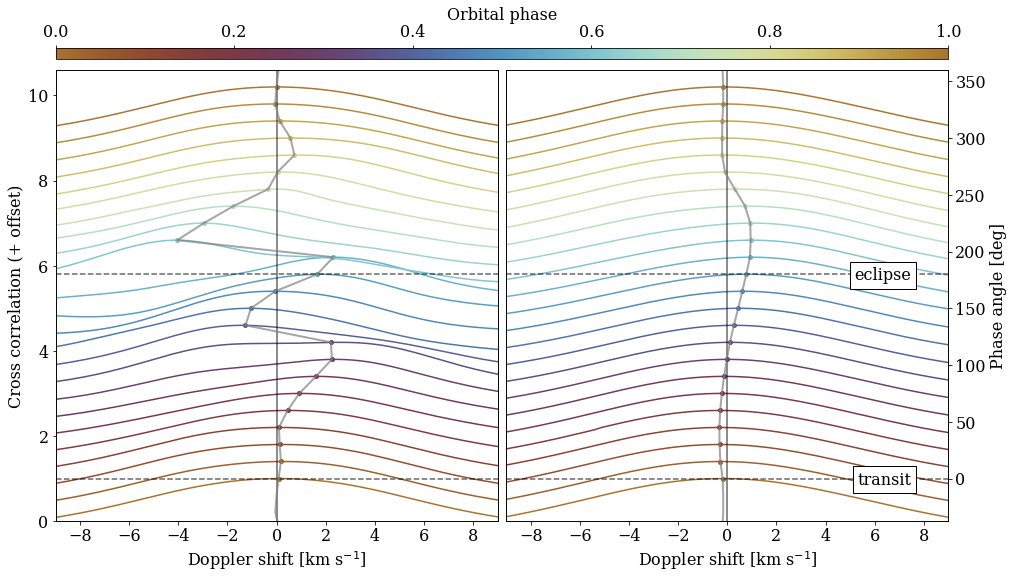

In [12]:
'''

Caleb Harada

plot CCFs for multiple phases and overplot RV as a function of phase


'''


import numpy as np
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import glob
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable




### ----- INPUT/OUTPUT ----- ###

savefile = '/home/imalsky/Desktop/test-ccfs.png'




### ----- GET FILES ----- ###

clear_files_dopp = f'/home/imalsky/Documents/2stream_caleb/OUT/extended_thick/*_dopp-ON_phase-*.dat'
clear_files_rest = f'/home/imalsky/Documents/2stream_caleb/OUT/extended_thick/*_dopp-OFF_phase-*.dat'


extended_thick_files_dopp = f'/home/imalsky/Documents/2stream_caleb/OUT/pp_extended_thick/*_dopp-ON_phase-*.dat'
extended_thick_files_rest = f'/home/imalsky/Documents/2stream_caleb/OUT/pp_extended_thick/*_dopp-OFF_phase-*.dat'







# set up CCF figure
font = {'size' : 16,
    'family' : 'serif'}
plt.rc('font', **font)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
plt.subplots_adjust(wspace=0.02, hspace=0)


# colormap
cm_name = 'romaO'
cm_file = np.loadtxt(f'/home/imalsky/Desktop/New_Jups/Code/ScientificColourMaps6/{cm_name}/{cm_name}-64.txt')
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])
colors = np.linspace(0, 256, 12)


def dopp_signatures(templates, signals, axis, phase_fmt='int'):

	### ----- LOAD DATA ----- ###

	templates = sorted(glob.glob(templates))
	signals = sorted(glob.glob(signals))

	phases = np.zeros(len(templates) + 1)
	RVs = np.zeros(len(templates) + 1)

	axis.set_xlim([-9, 9])
	axis.set_ylim([0, 10.6])

	# list of colors
	colors = np.linspace(0, 1, len(templates))

	# keep track of color and offset
	color_idx = 0
	offset = 0



	for i in range(len(templates)):

		# save orbital
		if phase_fmt == 'int':
			phase = int(templates[i][-7:-4])
		elif phase_fmt == 'float':
			phase = float(templates[i][-10:-4])
		else:
			print('ERROR\n Unrecognized phase format.')
			exit()

		print(phase)
		phases[i] = phase


		tw, tf = np.loadtxt(templates[i], unpack=True)
		dw, df = np.loadtxt(signals[i], unpack=True)
		#print(np.sum(tf))
		
		# Carry out the cross-correlation.
		# The RV-range is -10 to +10 km/s in steps of 0.1 km/s.
		# The first and last 200 points of the data are skipped.
		rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -10., 10., 0.1, mode='lin', skipedge=200)

		# normalize cc function 
		cc = (cc - min(cc)) / (max(cc) - min(cc))

		# Find the index of maximum cross-correlation function
		maxind = np.argmax(cc)


		# define Gaussian function
		def gaussian(x, a, x0, sigma):
		    return a * np.exp(-(x - x0) * (x - x0) / (2 * sigma * sigma))


		# fit Guassian to peak region of cc function
		rv_range = rv[maxind - 20: maxind + 20]
		cc_range = cc[maxind - 20: maxind + 20]

		popt, pcov = curve_fit(gaussian, rv_range, cc_range, p0=[1, 0, 1])


		# calculate best fit guassian
		rv_fit = np.linspace(rv[maxind - 20], rv[maxind + 20], 1000)
		cc_fit = gaussian(rv_fit, *popt)


		# index of maximum of Gaussian
		max_gauss = np.argmax(cc_fit)


		# save radial velocity
		RVs[i] = rv_fit[max_gauss]


		
		# plot CCFs
		axis.plot(rv, cc + offset, lw=1.5, color=my_colors(colors[color_idx]))
		axis.plot(rv_fit[max_gauss], cc_fit[max_gauss] + offset, '.', ms=8, color=my_colors(colors[color_idx]))


		offset += 0.4
		color_idx += 1



	phases[-1] = 360
	RVs[-1] = RVs[0]



	return RVs, phases
	



# phase_fmt must be int for clear case (sorry)
clear_RVs, clear_phases = dopp_signatures(clear_files_rest, clear_files_dopp, axes[0], phase_fmt='float')
cloudy_RVs, cloudy_phases = dopp_signatures(extended_thick_files_rest, extended_thick_files_dopp, axes[1], phase_fmt='float')


# plot RV line for clear case
clear_ax = axes[0].twinx()
clear_ax.set_ylim([-37.5, 360])
clear_ax.set_zorder(2)
clear_ax.yaxis.set_ticklabels([])
clear_ax.yaxis.set_ticks([])
clear_ax.patch.set_visible(False)
clear_ax.plot(clear_RVs, clear_phases, 'gray', lw=2, alpha=0.7)
clear_ax.plot(clear_RVs, clear_phases - 360, 'gray', lw=2, alpha=0.7)


# plot RV line for cloudy case
cloudy_ax = axes[1].twinx()
cloudy_ax.set_ylim([-37.5, 360])
cloudy_ax.set_zorder(2)
cloudy_ax.patch.set_visible(False)
cloudy_ax.plot(cloudy_RVs, cloudy_phases, 'gray', lw=2, alpha=0.7)
cloudy_ax.plot(cloudy_RVs, cloudy_phases - 360, 'gray', lw=2, alpha=0.7)

axes[1].yaxis.set_ticks([])

# lines
clear_ax.axvline(0, color='k', lw=1.5, ls='-', zorder=0, alpha=0.6)
cloudy_ax.axvline(0, color='k', lw=1.5, ls='-', zorder=0, alpha=0.6)

clear_ax.axhline(0, color='k', lw=1.5, ls='--', zorder=0, alpha=0.6)
cloudy_ax.axhline(0, color='k', lw=1.5, ls='--', zorder=0, alpha=0.6)
cloudy_ax.annotate('transit', xy=(0, 0), xycoords='data', xytext=(7.5, -5), bbox=dict(boxstyle='square', facecolor='white'), horizontalalignment='right')

clear_ax.axhline(180, color='k', lw=1.5, ls='--', zorder=0, alpha=0.6)
cloudy_ax.axhline(180, color='k', lw=1.5, ls='--', zorder=0, alpha=0.6)
cloudy_ax.annotate('eclipse', xy=(0, 180), xycoords='data', xytext=(7.5, 175), bbox=dict(boxstyle='square', facecolor='white'), horizontalalignment='right')


# labels

axes[0].set_xlabel('Doppler shift [km s$^{-1}$]')
axes[1].set_xlabel('Doppler shift [km s$^{-1}$]')
axes[0].set_ylabel('Cross correlation (+ offset)')

cloudy_ax.set_ylabel('Phase angle [deg]')



sm = plt.cm.ScalarMappable(cmap=my_colors, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), location='top', aspect=80, pad=0.02)
cbar.set_label('Orbital phase')



fig.savefig(savefile, bbox_inches='tight', dpi=300)











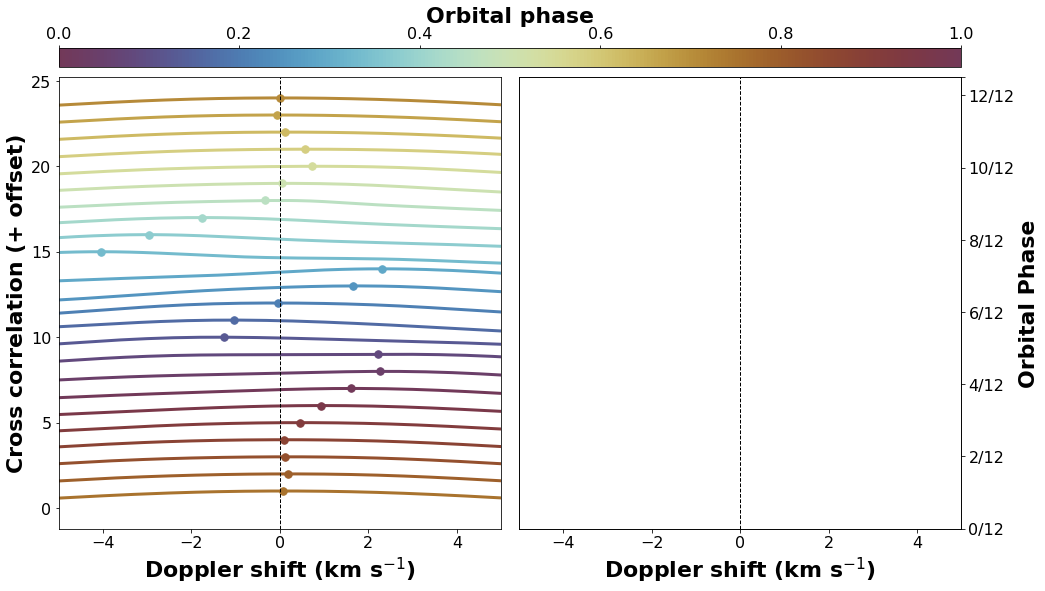

In [14]:
# Figure aesthetics
fig, axes = plt.subplots(1, 2, figsize=(16.18, 10))
plt.subplots_adjust(wspace=0.04, hspace=0)

font = {'size' : 16, 'family' : 'sans-serif'}
plt.rc('font', **font)

#'UPS-LOW-G-CLOUDY-250'

base = '/home/imalsky/Desktop/test/'

#inclinations = ['1.152']



phases = ['000.00', '015.00','030.00','045.00','060.00','075.00','090.00','105.00',
          '120.00', '135.00','150.00','165.00','180.00','195.00','210.00','225.00',
          '240.00', '255.00','270.00','285.00','300.00','315.00','330.00','345.00',]


#buda, batlow, roma, 
cm_name = 'romaO'
cm_file = np.loadtxt(f'ScientificColourMaps6/{cm_name}/{cm_name}.txt')
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])
colors = np.linspace(0, 256, len(phases) + 1)

# define Gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0) * (x - x0) / (2 * sigma * sigma))


i = 0
clear_list  = []
cloudy_list = []
for phase in phases:
    color_val = int(colors[i]) - 64
    if color_val < 0:
        color_val = color_val + 256  

    # Do the clear one!
    file1 = base + 'EXTENDED_THICK_clouds-ON_dopp-OFF_phase-{}.dat'.format(phase)
    file2 = base + 'EXTENDED_THICK_clouds-ON_dopp-ON_phase-{}.dat'.format(phase)

    tw, tf = np.loadtxt(file1, unpack=True)
    dw, df = np.loadtxt(file2, unpack=True)

    # Get the cross correlation
    rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -10., 10., 0.1, skipedge=200)

    # normalize cc function 
    cc = (cc - min(cc)) / (max(cc) - min(cc))

    # Find the index of maximum cross-correlation function
    maxind = np.argmax(cc)

    # fit Guassian to peak region of cc function
    rv_range = rv[maxind - 20: maxind + 20]
    cc_range = cc[maxind - 20: maxind + 20]

    popt, pcov = curve_fit(gaussian, rv_range, cc_range, p0=[1, 0, 1])

    # calculate best fit guassian
    rv_fit = np.linspace(rv[maxind - 20], rv[maxind + 20], 1000)
    cc_fit = gaussian(rv_fit, *popt)

    # index of maximum of Gaussian
    max_gauss = np.argmax(cc_fit) 

    # plot CCFs
    axes[0].plot(rv, cc + i, lw=3, color=my_colors(color_val))
    axes[0].plot(rv_fit[max_gauss], cc_fit[max_gauss] + i, '.', ms=15, color=my_colors(color_val))    
    clear_list.append(rv_fit[max_gauss])
    i = i+1

cloudy_ax = axes[1].twinx()
x_ticks_labels = ['0/12', '2/12', '4/12', '6/12', '8/12', '10/12', '12/12']

axes[1].yaxis.set_ticks([])
cloudy_ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 12.5])
cloudy_ax.set_yticklabels(x_ticks_labels)

#axes[0].xaxis.set_ticks([-5, -4, -2, 0, 2, 4, 6])
#axes[1].xaxis.set_ticks([-6, -4, -2, 0, 2, 4, 6])

axes[0].set_xlim(-5, 5)
axes[1].set_xlim(-5, 5)

axes[0].set_xlabel('Doppler shift (km s$^{-1}$)',fontsize=22, weight='bold')
axes[1].set_xlabel('Doppler shift (km s$^{-1}$)',fontsize=22, weight='bold')
axes[0].set_ylabel('Cross correlation (+ offset)',fontsize=22, weight='bold')

cloudy_ax.set_ylabel('Orbital Phase',fontsize=22, weight='bold')

axes[0].axvline(linewidth=1, color='k',linestyle='dashed')
axes[1].axvline(linewidth=1, color='k',linestyle='dashed')
    
sm = plt.cm.ScalarMappable(cmap=my_colors, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), location='top', aspect=50, pad=0.02)
cbar.set_label('Orbital phase', fontsize=22, weight='bold')
#plt.savefig('/home/imalsky/Desktop/ccs.png', bbox_inches='tight', dpi=200)